In [86]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Lecture 06
### Neural Network with :

- **FIFA Dataset**
- One hidden layer 
- ${Tanh}$ activation function
- **multi-class**


In [87]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Changes-----------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# Changes-----------------------------------

%matplotlib inline

In [88]:
###----------------
### Some parameters
###----------------

inpDir = '../../input'
outDir = '../output'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 5001 # number of epochs
ALPHA = 0.001 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

## Helper Functions

## Generate Data Set
FIFA 2019 Dataset

In [89]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [90]:
for col in data_df.columns:
    print (f'{col} : {data_df[col].unique()}')

Unnamed: 0 : [    0     1     2 ... 18204 18205 18206]
ID : [158023  20801 190871 ... 241638 246268 246269]
Name : ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age : [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo : ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality : ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Algeria' 'Austria'
 'Greece' 'Chile' 'Sweden' 'Korea Republic' 'Finland' 'Guinea'
 'Montenegro' 'Armenia' '

In [91]:
data_df.isnull().sum()

Unnamed: 0           0
ID                   0
Name                 0
Age                  0
Photo                0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 89, dtype: int64

In [92]:
data_df = data_df [data_df['Position'].notnull()]
data_df.shape

(18147, 89)

In [93]:
data_df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [94]:
rel_columns = ['Position','Finishing',  'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']

"""['Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', ,
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       , ,  'Release Clause']"""

"['Name', 'Age', 'Photo', 'Nationality', 'Flag',\n       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',\n       'Preferred Foot', 'International Reputation', 'Weak Foot',\n       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', ,\n       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',\n       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',\n       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',\n       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',\n       , ,  'Release Clause']"

In [95]:
data_df = data_df[rel_columns]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [96]:
data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [97]:
data_df.Position.unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [98]:
goalkeeper = 'GK'

forward = [ 'ST', 'LW', 'RW', 'LF', 'RF', 'RS', 'LS', 'CF']
midfielders = ['CM', 'RCM', 'LCM', 'CDM', 'RDM', 'LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defence = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB',  'RB']

In [99]:
data_df.loc[data_df['Position'] == 'GK' ,          'Position'] = 0

data_df.loc[data_df['Position'].isin(defence) ,    'Position'] = 1

data_df.loc[data_df['Position'].isin(midfielders), 'Position'] = 2

data_df.loc[data_df['Position'].isin(forward) ,    'Position'] = 3

data_df['Position'] =pd.to_numeric(data_df['Position'], downcast='integer')

In [100]:
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [101]:
data_df['Position'].unique()

array([3, 0, 2, 1], dtype=int8)

In [102]:
labels = { 0 : 'Goal Keepers', 1: 'Defence', 2: 'Mid-fielders', 3: 'Forward'}

In [103]:
features_df = data_df.drop('Position', axis = 1) # drop label col

label_df = data_df['Position'] # labels

features_df.shape, label_df.shape

((18147, 33), (18147,))

In [104]:
label_df = pd.get_dummies(label_df)
label_df

,0,1,2,3
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,True,False,False,False
4,False,False,True,False
...,...,...,...,...
18202,False,False,True,False
18203,False,False,False,True
18204,False,False,False,True
18205,False,False,False,True


In [105]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(features_df, label_df, 
                                                    stratify=label_df,
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517, 4) (3630, 33) (3630, 4)


In [106]:
scaler = StandardScaler() # get the scaler

X_train = scaler.fit_transform(X_train) # train
X_test = scaler.transform(X_test) # test

y_train = y_train.to_numpy() # array
y_test = y_test.to_numpy() # convert to array
y_test.shape, y_train.shape

((3630, 4), (14517, 4))

In [107]:
y_train

array([[False,  True, False, False],
       [False, False,  True, False],
       [False,  True, False, False],
       ...,
       [False, False,  True, False],
       [False, False, False,  True],
       [ True, False, False, False]])

## Neural Network

Let's start with simple network. Our data has **two** features. Hence size of input layer will also be two. Lets code our output as two classes. The hidden layer could be of **any size**. One need to execute a handful of iterations to arrive at right size of hidden layer. For purpose of today's discussions, size of hidden layer is taken as shown below.

<img src='../../images/dnn_nb_s05_fig1.png' width = '500' alt = 'Session 5 Figure 1'/>

## Prepare model

In [108]:
torch.version.cuda

'12.1'

In [109]:
torch.cuda.current_device()

0

In [110]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce GTX 1650'

In [111]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [112]:
class Model(nn.Module):

    def __init__ (self, input_dim):

        super (Model, self).__init__()

        self.layer1 = nn.Linear(input_dim, 18)
        self.layer2 = nn.Linear(18, 4)

    def forward(self, x):

        x = F.tanh(self.layer1(x) ) # layer 1

        x = F.softmax( self.layer2(x), dim = 1 ) # layer 2

        return x

In [113]:
model = Model(X_train.shape[1]).to(device)
print(model)

Model(
  (layer1): Linear(in_features=33, out_features=18, bias=True)
  (layer2): Linear(in_features=18, out_features=4, bias=True)
)


In [114]:
list(model.parameters())

[Parameter containing:
 tensor([[-1.2947e-01,  3.0390e-02, -1.0414e-01,  7.3791e-02, -1.2002e-01,
          -1.2614e-01,  6.7919e-02,  1.2760e-01, -7.1263e-02,  9.5626e-02,
           1.0032e-01, -6.7906e-02, -1.0464e-01, -6.9965e-02, -6.7402e-02,
          -1.0013e-01, -1.2766e-01, -1.0585e-01, -6.6561e-02, -1.5215e-02,
          -1.1001e-01,  1.0446e-01,  1.6664e-01, -4.7779e-02, -1.0709e-01,
           8.0389e-02, -8.3703e-02,  1.2207e-01,  1.4972e-01,  3.5061e-02,
          -1.6251e-01, -2.2433e-02, -1.2191e-01],
         [ 1.2045e-01, -1.1678e-01,  4.7664e-02,  1.1423e-01,  1.4479e-01,
          -2.4843e-02, -2.2394e-02, -1.1832e-01, -1.4392e-01,  1.5185e-01,
           1.2719e-01, -2.8309e-03,  6.9628e-02, -1.1094e-01,  5.2619e-03,
           1.0354e-01, -1.2294e-01,  1.1259e-01, -2.6852e-02, -5.5227e-02,
          -8.5004e-02, -1.3616e-01,  1.5898e-01,  1.5246e-01, -1.2324e-01,
           1.6313e-01, -6.7576e-02,  1.6870e-01,  1.0427e-02, -1.6452e-01,
          -1.1935e-01,  1.3

In [115]:
print (f' Number of parameters {len(list(model.parameters()))}')

 Number of parameters 4


In [116]:
print (f' Layer 1 Weights {(list(model.parameters())[0].shape)}')
print (f' Layer 1 Bias    {(list(model.parameters())[1].shape)}')
print (f' Layer 2 Weights {(list(model.parameters())[2].shape)}')
print (f' Layer 2 Bias    {(list(model.parameters())[3].shape)}')

 Layer 1 Weights torch.Size([18, 33])
 Layer 1 Bias    torch.Size([18])
 Layer 2 Weights torch.Size([4, 18])
 Layer 2 Bias    torch.Size([4])


In [117]:
train_X = Variable(torch.Tensor(X_train)).to(device)
train_y = Variable(torch.Tensor(y_train)).to(device)
test_X  = Variable(torch.Tensor(X_test)).to(device)
test_y  = Variable(torch.Tensor(y_test)).to(device)
train_y.shape, test_y.shape

(torch.Size([14517, 4]), torch.Size([3630, 4]))

In [130]:
loss_fn = nn.CrossEntropyLoss()

loss = []
tloss = []
n_epoch = []
acc = []
tacc = []

optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)  # optimizer


# Iteration

for epoch in range(EPOCHS):
    model.train()  # Set the mode

    predict_prob = model(train_X)
    print(predict_prob.shape)

    curr_loss = loss_fn(predict_prob, train_y)
    print(curr_loss.shape)

    ###----------
    ### Back prop
    ###----------
    optimizer.zero_grad()
    curr_loss.backward()
    optimizer.step()
    ###-----------------

    loss.append(curr_loss.data.item())

    _, y_pred = torch.max(predict_prob, 1)

    curr_acc = accuracy_score(y_train.argmax(axis=1), y_pred.data.cpu())

    acc.append(curr_acc)

    model.eval()

    pred_prob_tst = model(test_X)

    tcurr_loss = loss_fn(pred_prob_tst, test_y)

    tloss.append(tcurr_loss.data.item())

    _, y_pred = torch.max(pred_prob_tst, 1)

    curr_acc_ts = accuracy_score(y_test.argmax(axis=1), y_pred.data.cpu())

    tacc.append(curr_acc_ts)

    n_epoch.append(epoch)

    if epoch % 100 == 0:
        print(
            f"epoch: {epoch} --- Loss {curr_loss.data.item():.3f}/{tcurr_loss.data.item():.3f}",
            end="",
        )
        print(f"--- Acc {curr_acc:.3f}/{curr_acc_ts:.3f}")

torch.Size([14517, 4])
torch.Size([])
epoch: 0 --- Loss 1.370/1.366--- Acc 0.359/0.380
torch.Size([14517, 4])
torch.Size([])


In [119]:
list(model.parameters())

[Parameter containing:
 tensor([[-1.3047e-01,  2.9390e-02, -1.0514e-01,  7.2791e-02, -1.2102e-01,
          -1.2714e-01,  6.6919e-02,  1.2660e-01, -7.2263e-02,  9.4626e-02,
           9.9323e-02, -6.8906e-02, -1.0564e-01, -7.0965e-02, -6.8402e-02,
          -9.9130e-02, -1.2866e-01, -1.0485e-01, -6.7561e-02, -1.6215e-02,
          -1.1101e-01,  1.0346e-01,  1.6564e-01, -4.8779e-02, -1.0809e-01,
           7.9389e-02, -8.4703e-02,  1.2107e-01,  1.5072e-01,  3.6061e-02,
          -1.6151e-01, -2.1433e-02, -1.2091e-01],
         [ 1.2145e-01, -1.1778e-01,  4.6664e-02,  1.1523e-01,  1.4379e-01,
          -2.5843e-02, -2.3394e-02, -1.1932e-01, -1.4492e-01,  1.5085e-01,
           1.2619e-01, -1.8310e-03,  7.0628e-02, -1.1194e-01,  6.2619e-03,
           1.0254e-01, -1.2394e-01,  1.1159e-01, -2.5852e-02, -5.6227e-02,
          -8.6004e-02, -1.3516e-01,  1.5998e-01,  1.5346e-01, -1.2424e-01,
           1.6213e-01, -6.8576e-02,  1.6770e-01,  1.1427e-02, -1.6352e-01,
          -1.1835e-01,  1.3

In [120]:
loss_df = pd.DataFrame({'epoch': n_epoch, 
                        'loss': loss, 
                        'test loss': tloss,
                        'acc': acc, 
                        'test acc': tacc
                       })

In [131]:
loss_df.head()

,epoch,loss,test loss,acc,test acc
0,0,1.388324,1.38405,0.27051,0.293388


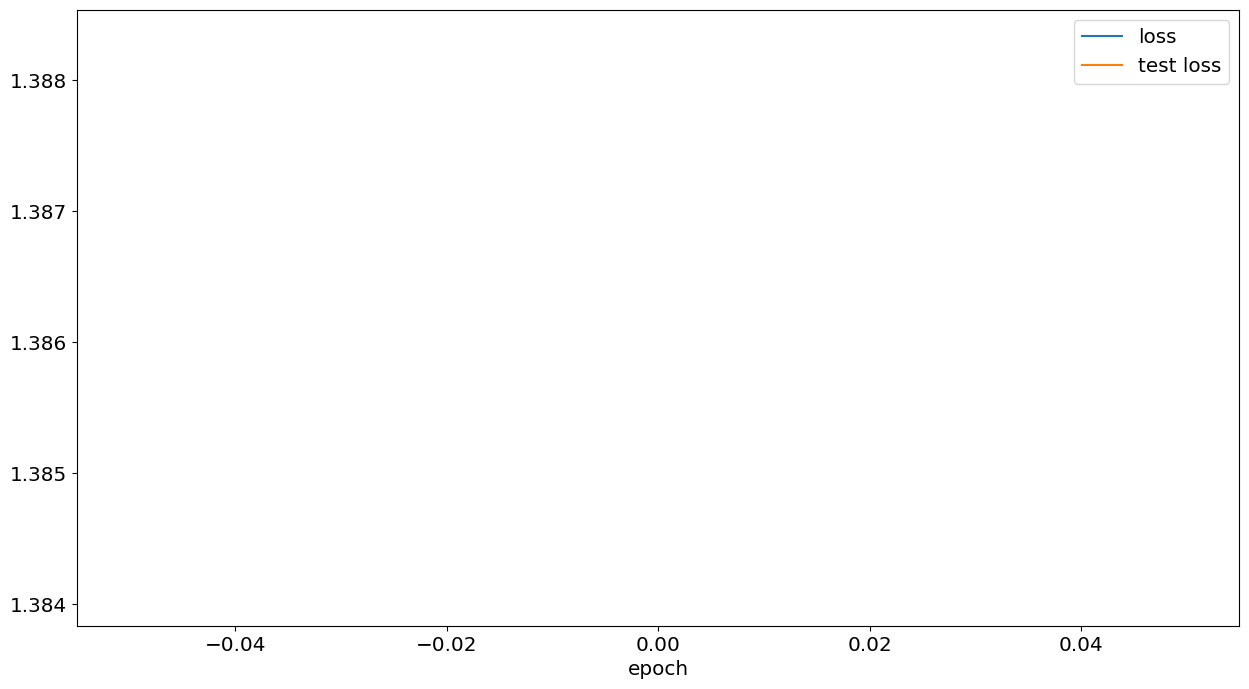

In [122]:
loss_df.plot(x = 'epoch', y = ['loss', 'test loss']);

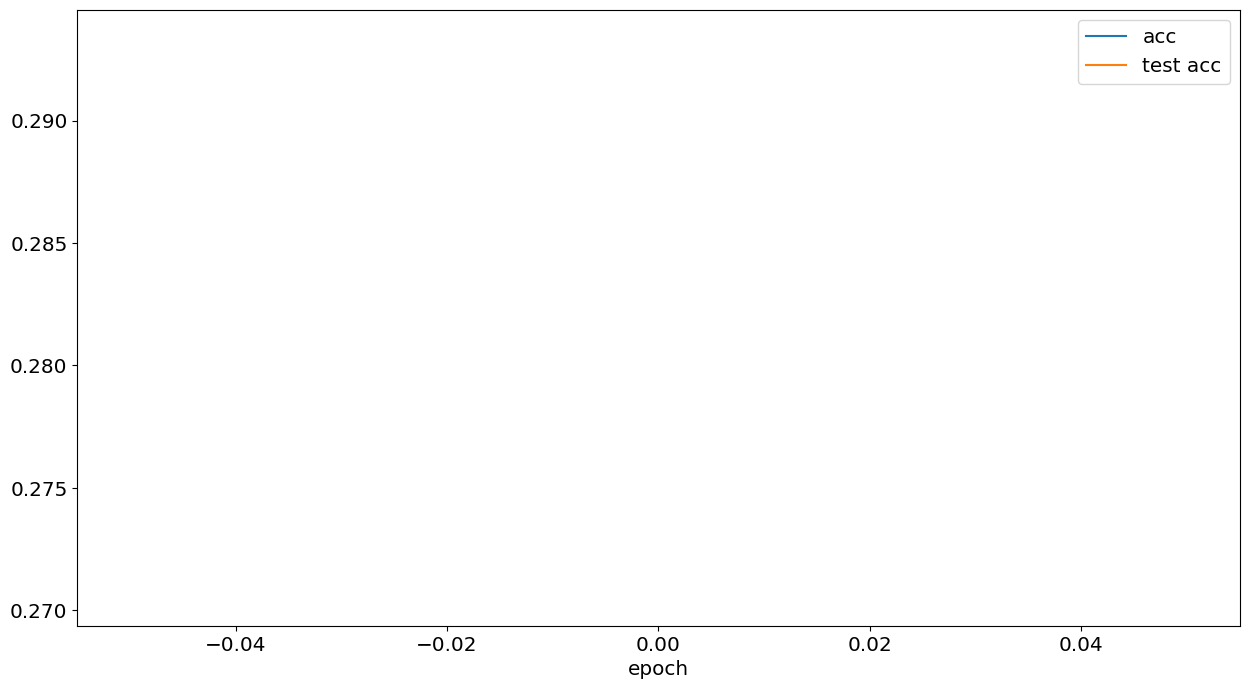

In [123]:
loss_df.plot(x = 'epoch', y = ['acc', 'test acc']);

### Test Data

In [124]:
pred_prob = model(test_X)
_, y_pred = torch.max(pred_prob, 1)
    
curr_acc_ts = accuracy_score(y_test.argmax(axis = 1), y_pred.data.cpu())

print(f'Accuracy score on Test Data : {curr_acc_ts: .4f}')

Accuracy score on Test Data :  0.2934


In [125]:
y_pred = y_pred.cpu()
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       405
           1       0.85      0.52      0.65      1173
           2       0.53      0.33      0.40      1368
           3       0.01      0.01      0.01       684

    accuracy                           0.29      3630
   macro avg       0.35      0.21      0.26      3630
weighted avg       0.48      0.29      0.36      3630



In [126]:
## Confusion Matrix helps

cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
cm

array([[  0,   2,   0, 403],
       [233, 613, 263,  64],
       [824,  92, 448,   4],
       [529,  12, 139,   4]], dtype=int64)

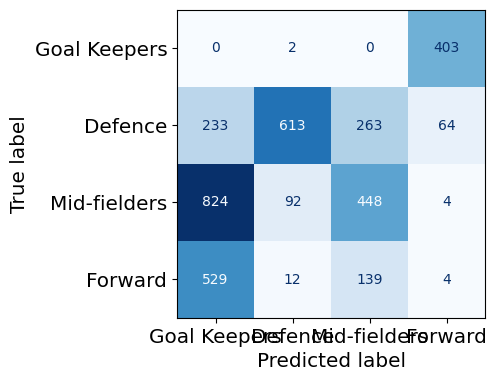

In [127]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels = labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();